In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import sys
import glob

In [2]:
sys.path.insert(0,"../src/ext-libraries/SingularSpectrumAnalysis/")
from mySSA import mySSA

In [3]:
def load_data(path, resampling=None):
    ## some resampling options: 'H' - hourly, '15min' - 15 minutes, 'M' - montlhy
    ## more options at:
    ## http://benalexkeen.com/resampling-time-series-data-with-pandas/
    allFiles = glob.iglob(path + "/**/*.txt", recursive=True)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        #print("Reading: ",file_)
        df = pd.read_csv(file_,index_col="datetime",parse_dates=['datetime'], header=0, sep=",")
        if frame.columns is None :
            frame.columns = df.columns
        list_.append(df)
    frame = pd.concat(list_)
    if resampling is not None:
        frame = frame.resample(resampling).mean()
    frame = frame.fillna(method='ffill')
    return frame

In [4]:
path = '/Users/cseveriano/spatio-temporal-forecasting/data/processed/NREL/Oahu'

df = load_data(path)

# Corrigir ordem das colunas
df.columns = ['DHHL_3','DHHL_4', 'DHHL_5', 'DHHL_10', 'DHHL_11', 'DHHL_9', 'DHHL_2', 'DHHL_1', 'DHHL_1_Tilt', 'AP_6', 'AP_6_Tilt', 'AP_1', 'AP_3', 'AP_5', 'AP_4', 'AP_7', 'DHHL_6', 'DHHL_7', 'DHHL_8']
#inicio dos dados possui falhas na medicao
df = df.loc[df.index > '2010-03-20']
df.drop(['AP_3', 'DHHL_1_Tilt', 'AP_6_Tilt'], axis=1, inplace=True)

In [5]:
df.to_pickle("df_oahu.pkl")

In [53]:
dt = []
p_inds = [i for i in range(3)]
df_clean = pd.DataFrame(columns=df.columns)
df_residual = pd.DataFrame(columns=df.columns)

for c in df.columns:
    dfc = df[c]
    cl = []
    rs = []
    for date in df.index.to_period('M').unique():
        ts = dfc[str(date)]
        N = int(len(ts)) # number of samples
        T = 96 # sample daily frequency (4 samples per hour)
        embedding_dimension =  int(N / T)
        ssa = mySSA(ts)
        ssa.embed(embedding_dimension=embedding_dimension,verbose=True)
        res_streams = [j for j in range(3,embedding_dimension)]
        ssa.decompose(verbose=True)
        principal = ssa.view_reconstruction(*[ssa.Xs[i] for i in p_inds], names=p_inds, plot=False, return_df=True)
        residual = ssa.view_reconstruction(*[ssa.Xs[i] for i in res_streams], names=res_streams, plot=False, return_df=True)
        
        cl.extend(list(principal['Reconstruction']))
        rs.extend(list(residual['Reconstruction']))
    df_clean[c] = cl
    df_residual[c] = rs

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  7
Trajectory dimensions	: (7, 726)
Complete dimension	: (7, 726)
Missing dimension     	: (7, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 7
Dimension of projection space	: 7
Characteristic of projection	: 1.0
----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  19
Trajectory dimensions	: (19, 1812)
Complete dimension	: (19, 1812)
Missing dimension     	: (19, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 19
Dimension of projection space	: 19
Characteristic of projection	: 1.0
----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  19
Trajectory dimensions	: (19, 1873)
Complete dimension	: (19, 1873)
Missing dimension     	: (19, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 19
Dimension of projection space	: 19
Characte

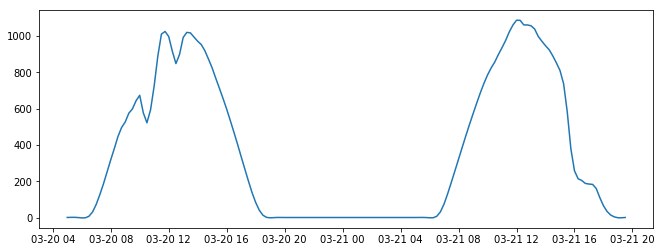

In [60]:
plt.plot(df_clean['DHHL_3'].iloc[0:120])

In [57]:
df_clean.index = df.index
df_residual.index = df.index

In [61]:
df_clean.to_pickle("df_ssa_clean.pkl")
df_residual.to_pickle("df_ssa_residual.pkl")